# OCR model for reading Captchas

This notebook demonstrates a simple OCR model built with the Functional API. Apart from combining CNN and RNN, it also illustrates how you can intantiate a new layer and use it as an "Endpoint layer" for implementing CTC loss. 

# Setup

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path 
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
pip list

In [5]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

tensorflow==2.3.1
numpy==1.18.5
matplotlib==3.2.1


# Load the data: Captcha Images

In [2]:
# !curl -LO www.kaggle.com/rajesh1999/captcha.zip

# !unzip -qq captcha.zip


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [4]:
# Path to the data directory
data_dir = Path("../input/captcha/captcha_samples/")


# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print(f"Number of images found: {len(images)}")
print(f"Number of labels found: {len(labels)}")
print(f"Number of unique characters: {len(characters)}")
print(f"Characters present: {characters}")

Number of images found: 9621
Number of labels found: 9621
Number of unique characters: 34
Characters present: {'I', 'N', 'Q', 'Y', 'T', 'F', 'Z', 'D', 'X', 'E', 'P', '8', '2', 'S', 'L', 'H', 'M', 'A', 'V', 'W', '5', '6', 'C', 'B', 'R', '1', '7', '3', '9', 'G', 'U', 'J', '4', 'K'}


The dataset contains `1040` captcha files as `png` images. The label for each sample is a string, the name of the file (minus the file extension). We will map each character in the string to an integer for training the model. Similarly, we will need to map the predictions of the model back to strings. 

In [5]:
# Batch size for training and validation
batch_size = 32

# Desired image dimensions
img_width = 100
img_height = 40

# Factor by which the image is going to be downsampled by the convolutional blocks.
# We will be using two convolution blocks and each block will have a pooling layer
# which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

# Preprocessing

In [6]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.7, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]] 
    return x_train, x_valid, y_train, y_valid

def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [7]:
# Splitting data into training and validation sets
X_train, X_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

print(f"X_Train shape: {X_train.shape}")
print(f"y_Train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_Train shape: (6734,)
y_Train shape: (6734,)
X_valid shape: (2887,)
y_valid shape: (2887,)


# Create dataset objects

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

# Visualize the data

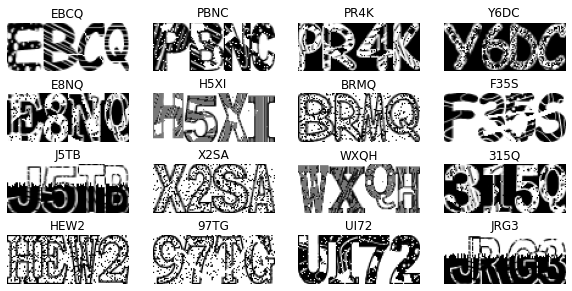

In [9]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Model

In [10]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        
    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # At test, just return the computed predictions
        return y_pred
    
def build_model():
    # Inputs the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
    # First conv block
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    
    # Second conv block
    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller.
    # The number of filters in the last layer is 64. 
    # Reshape accordingly before passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    
    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)
    
    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)
    
    # Define the model 
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

In [11]:
# Get the model

model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 100, 40, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 100, 40, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 50, 20, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 50, 20, 64)   18496       pool1[0][0]                      
_______________________________________________________________________________________

# Training

In [12]:
epochs = 100
early_stopping_patience = 10

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset, 
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/100
211/211 [==============================] - 19s 88ms/step - loss: 16.0424 - val_loss: 15.4543
Epoch 2/100
211/211 [==============================] - 10s 47ms/step - loss: 15.0360 - val_loss: 14.5167
Epoch 3/100
211/211 [==============================] - 10s 49ms/step - loss: 14.1126 - val_loss: 13.9206
Epoch 4/100
211/211 [==============================] - 10s 47ms/step - loss: 13.5471 - val_loss: 12.8217
Epoch 5/100
211/211 [==============================] - 10s 47ms/step - loss: 12.1270 - val_loss: 11.1369
Epoch 6/100
211/211 [==============================] - 11s 51ms/step - loss: 10.6808 - val_loss: 9.6038
Epoch 7/100
211/211 [==============================] - 10s 48ms/step - loss: 9.4129 - val_loss: 8.4001
Epoch 8/100
211/211 [==============================] - 10s 47ms/step - loss: 8.2683 - val_loss: 7.3140
Epoch 9/100
211/211 [==============================] - 10s 49ms/step - loss: 7.2234 - val_loss: 6.1779
Epoch 10/100
211/211 [==============================] - 10s 47

# Inference

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 100, 40, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 100, 40, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 20, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 50, 20, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 25, 10, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 25, 640)           0         
_________________________________________________________________
dense1 (Dense)               (None, 25, 64)           

IndexError: index 4 is out of bounds for axis 0 with size 4

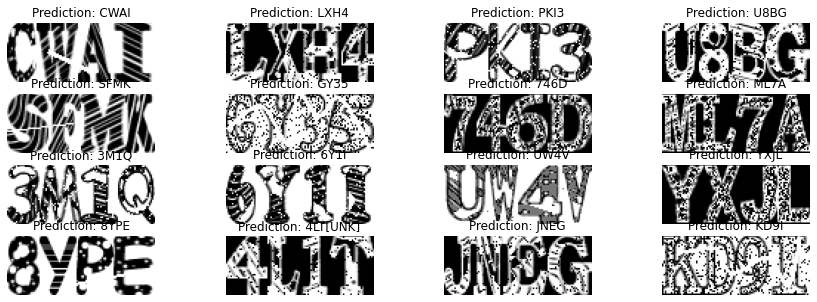

In [13]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, : max_length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

# Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
        
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")        
plt.show()

In [14]:
prediction_model.save('/kaggle/working/final_model.h5')


In [15]:
from tensorflow import keras

model_loaded = keras.models.load_model('/kaggle/working/final_model.h5')

IndexError: index 4 is out of bounds for axis 0 with size 4

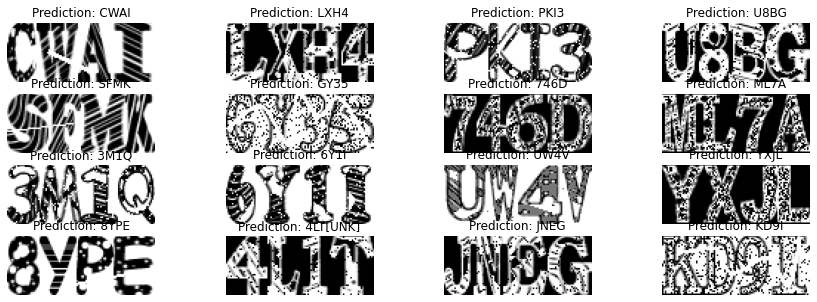

In [16]:


# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, : max_length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

# Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    
    preds = model_loaded.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
        
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")        
plt.show()

In [18]:
images_all = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels_all = [img.split(os.path.sep)[-1].split(".png")[0] for img in images_all]


dataset = tf.data.Dataset.from_tensor_slices((np.array(images_all), np.array(labels_all)))
dataset = (
    dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [19]:
import pandas as pd


In [20]:
# Let's check results on some validation samples
orig_texts_all=[]
pred_text_all=[]

for batch in dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]
    
    preds = model_loaded.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
    orig_texts_all+=orig_texts
    pred_text_all+=pred_texts

    

In [21]:
print('overall accuracy')
 
df_all = pd.DataFrame(orig_texts_all,columns=['original_text'])
df_all['prediction_text'] = pred_text_all
df_all['predicted_correct'] = df_all['original_text']==df_all['prediction_text']
(df_all['predicted_correct'].value_counts()/len(df_all))*100

overall accuracy


True     98.513668
False     1.486332
Name: predicted_correct, dtype: float64

In [22]:
# Let's check results on some validation samples
orig_texts_test=[]
pred_text_test=[]

for batch in validation_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]
    
    preds = model_loaded.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
    orig_texts_test+=orig_texts
    pred_text_test+=pred_texts

print('test accuracy')
    
df_test = pd.DataFrame(orig_texts_test,columns=['original_text'])
df_test['prediction_text'] = pred_text_test
df_test['predicted_correct'] = df_test['original_text']==df_test['prediction_text']
(df_test['predicted_correct'].value_counts()/len(df_test))*100

    

test accuracy


True     95.046761
False     4.953239
Name: predicted_correct, dtype: float64

In [23]:
# Let's check results on some validation samples
# Let's check results on some validation samples
orig_texts_train=[]
pred_text_train=[]

for batch in train_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]
    
    preds = model_loaded.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
    orig_texts_train+=orig_texts
    pred_text_train+=pred_texts

print('train accuracy')
df_train = pd.DataFrame(orig_texts_train,columns=['original_text'])
df_train['prediction_text'] = pred_text_train
df_train['predicted_correct'] = df_train['original_text']==df_train['prediction_text']
(df_train['predicted_correct'].value_counts()/len(df_train))*100

    

train accuracy


True    100.0
Name: predicted_correct, dtype: float64

In [24]:
char_to_num.get_vocabulary()

['I',
 'N',
 'Q',
 'Y',
 'T',
 'F',
 'Z',
 'D',
 'X',
 'E',
 'P',
 '8',
 '2',
 'S',
 'L',
 'H',
 'M',
 'A',
 'V',
 'W',
 '5',
 '6',
 'C',
 'B',
 'R',
 '1',
 '7',
 '3',
 '9',
 'G',
 'U',
 'J',
 '4',
 'K']

In [ ]:
a

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path 
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model_loaded = keras.models.load_model('../input/final-model/final_model.h5')
img_width = 100
img_height = 40
# Mapping integers back to original characters
num_to_char_1 = layers.experimental.preprocessing.StringLookup(
    vocabulary=['I',
 'N',
 'Q',
 'Y',
 'T',
 'F',
 'Z',
 'D',
 'X',
 'E',
 'P',
 '8',
 '2',
 'S',
 'L',
 'H',
 'M',
 'A',
 'V',
 'W',
 '5',
 '6',
 'C',
 'B',
 'R',
 '1',
 '7',
 '3',
 '9',
 'G',
 'U',
 'J',
 '4',
 'K'], mask_token=None, invert=True
)


def encode_single_sample(img_path):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    img = tf.expand_dims(img, axis=0)
    # 6. Map the characters in label to numbers
    preds = model_loaded.predict(img)
    pred_texts = decode_batch_predictions(preds)
    return pred_texts

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    print(input_len)

    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, : 4]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char_1(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


encode_single_sample('../input/captcha/captcha_samples/ZQFN.png')

[25.]


['ZQFN']

In [1]:
from platform import python_version

In [2]:
python_version()

'3.7.6'

In [1]:
pip list

Package                            Version             Location
---------------------------------- ------------------- --------------
absl-py                            0.10.0
adal                               1.2.2
affine                             2.3.0
aiobotocore                        1.1.2
aiohttp                            3.7.3
aiohttp-cors                       0.7.0
aioitertools                       0.7.1
aioredis                           1.3.1
alabaster                          0.7.12
albumentations                     0.5.2
alembic                            1.4.3
allennlp                           1.2.2
altair                             4.1.0
anaconda-client                    1.7.2
anaconda-project                   0.8.3
annoy                              1.17.0
ansiwrap                           0.8.4
appdirs                            1.4.3
argh                               0.26.2
arrow                              0.15.5
arviz                              0.10.0